# Step 1.1 - Prepare network data
## Project: Growing Urban Bicycle Networks

This notebook downloads bicycle and street network data sets and prepares them for analysis.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-09  
Last modified: 2021-03-10

## Preliminaries

### Parameters

In [1]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [2]:
%run -i path.py
#%run -i setup.py
%run -i setupCPH.py

%load_ext watermark
%watermark -n -v -m -g -iv
import statistics

Loaded PATH.

Setup finished.

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 8.5.0

Compiler    : Clang 9.0.1 
OS          : Darwin
Release     : 18.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 825e44fc75de9c09a3fdbabb00d8c3f3a4008573

watermark : 2.3.1
geojson   : 2.5.0
networkx  : 2.8.6
matplotlib: 3.6.0
osgeo     : 3.2.1
geopandas : 0.11.1
csv       : 1.0
osmnx     : 0.16.2
fiona     : 1.8.21
sklearn   : 1.1.2
igraph    : 0.9.1
pyproj    : 3.4.0
shapely   : 1.8.4
numpy     : 1.23.3
pandas    : 1.4.4
sys       : 3.8.2 | packaged by conda-forge | (default, Apr 24 2020, 07:56:27) 
[Clang 9.0.1 ]



### Functions

In [3]:
%run -i functions.py

Loaded functions.



## Download and wrangle data

### Networks

In [4]:
for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
        if debug: # Draw location polygons and their holes
            try:
                color = cm.rainbow(np.linspace(0,1,len(location)))
                for poly,c in zip(location, color):
                    plt.plot(*poly.exterior.xy, c = c)
                    for intr in poly.interiors:
                        plt.plot(*intr.xy, c = "red")
            except:
                plt.plot(*location.exterior.xy)
            plt.show()
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        location = shapely.geometry.shape(first['geometry'])
    
    Gs = {}
    for parameterid, parameterinfo in tqdm(osmnxparameters.items(), desc = "Networks", leave = False):
        for i in range(0,10): # retry
            try:
                Gs[parameterid] = ox.graph_from_polygon(location, 
                                       network_type = parameterinfo['network_type'],
                                       custom_filter = (parameterinfo['custom_filter']),
                                       retain_all = parameterinfo['retain_all'],
                                       simplify = False)
            except ValueError:
                Gs[parameterid] = nx.empty_graph(create_using = nx.MultiDiGraph)
                print(placeid + ": No OSM data for graph " + parameterid + ". Created empty graph.")
                break
            except ConnectionError or UnboundLocalError:
                print("ConnectionError or UnboundLocalError. Retrying.")
                continue
            except:
                print("Other error. Retrying.")
                continue
            break
        if parameterinfo['export']: ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)

    # Compose special cases biketrack, bikeable, biketrackcarall
    parameterid = 'biketrack'
    Gs[parameterid] = nx.compose_all([Gs['bike_cyclewaylefttrack'], Gs['bike_cyclewaytrack'], Gs['bike_highwaycycleway'], Gs['bike_bicycleroad'], Gs['bike_cyclewayrighttrack'], Gs['bike_designatedpath'], Gs['bike_cyclestreet']])
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid+"_newdata" + "/", placeid, parameterid)
    
    parameterid = 'bikeable'
    Gs[parameterid] = nx.compose_all([Gs['biketrack'], Gs['car30'], Gs['bike_livingstreet']]) 
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)
    
    parameterid = 'biketrackcarall'
    Gs[parameterid] = nx.compose(Gs['biketrack'], Gs['carall']) # Order is important
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)
    
    print([k for k in Gs ])
    
    for parameterid in networktypes[:-2]:
        #G_temp = nx.MultiDiGraph(ox.utils_graph.get_digraph(ox.simplify_graph(Gs[parameterid]))) # This doesnt work - cant get rid of multiedges
        ox_to_csv(ox.simplify_graph(Gs[parameterid]), PATH["data"] + placeid + "/", placeid, parameterid, "_simplified")

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

Networks:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


copenhagen: Successfully wrote graph car30


/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


copenhagen: Successfully wrote graph carall


/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/si

copenhagen: Successfully wrote graph biketrack
copenhagen: Successfully wrote graph bikeable
copenhagen: Successfully wrote graph biketrackcarall
['car30', 'carall', 'bike_cyclewaytrack', 'bike_highwaycycleway', 'bike_designatedpath', 'bike_cyclewayrighttrack', 'bike_cyclewaylefttrack', 'bike_cyclestreet', 'bike_bicycleroad', 'bike_livingstreet', 'biketrack', 'bikeable', 'biketrackcarall']
copenhagen: Successfully wrote graph biketrack_simplified
copenhagen: Successfully wrote graph carall_simplified
copenhagen: Successfully wrote graph bikeable_simplified
copenhagen: Successfully wrote graph biketrackcarall_simplified


In [5]:
# Compress all data files (will not do anything if files were compressed already)
for folder, subfolders, files in os.walk(PATH["data"]):
    for file in files:
        if file.endswith('es.csv'):
            compress_file(folder + "/", file.split(".")[0])

## Frequency distribution of 'length_attr'

In [6]:
len_dict = nx.get_edge_attributes(Gs['carall'], "length")

normalise_edge_dict(len_dict)

len_dict_list = list(len_dict.values())

i=-1
for e in Gs['carall'].edges():
    i+=1
    a,b = e
    nx.set_edge_attributes(Gs['carall'], {(a,b,0): {"length_attr": len_dict_list[i] }})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


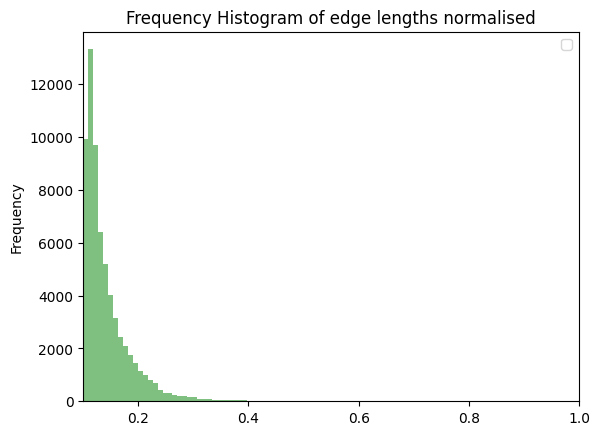

In [7]:
dict_to_histogram(len_dict, "edge lengths normalised")

In [8]:
length_attr_mean = statistics.mean([k for k in len_dict.values()])

with open('../../bikenwgrowth_external/data/copenhagen/bikedata/mean_length_attr.pkl', 'wb') as f:
    pickle.dump(length_attr_mean, f)

with open('../../bikenwgrowth_external/data/copenhagen/bikedata/edges_dict_length_attr.pkl', 'wb') as f:
    pickle.dump(len_dict, f)

ox_to_csv(Gs['carall'], PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall')
ox_to_csv(ox.simplify_graph(Gs['carall']), PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall', "_simplified")
ox.save_graphml(Gs['carall'], "../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml")

copenhagen: Successfully wrote graph carall
copenhagen: Successfully wrote graph carall_simplified


In [9]:
Audio(sound_file, autoplay=True)

# Calculate betweenness centrality for length_attr

In [10]:
btw_length = nx.edge_betweenness_centrality(Gs['carall'],  weight='length_attr')

In [30]:
with open("../../bikenwgrowth_external/data/copenhagen/bikedata/btw_length.pickle", 'wb') as f:
    pickle.dump(btw_length_attr_norm, f)

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


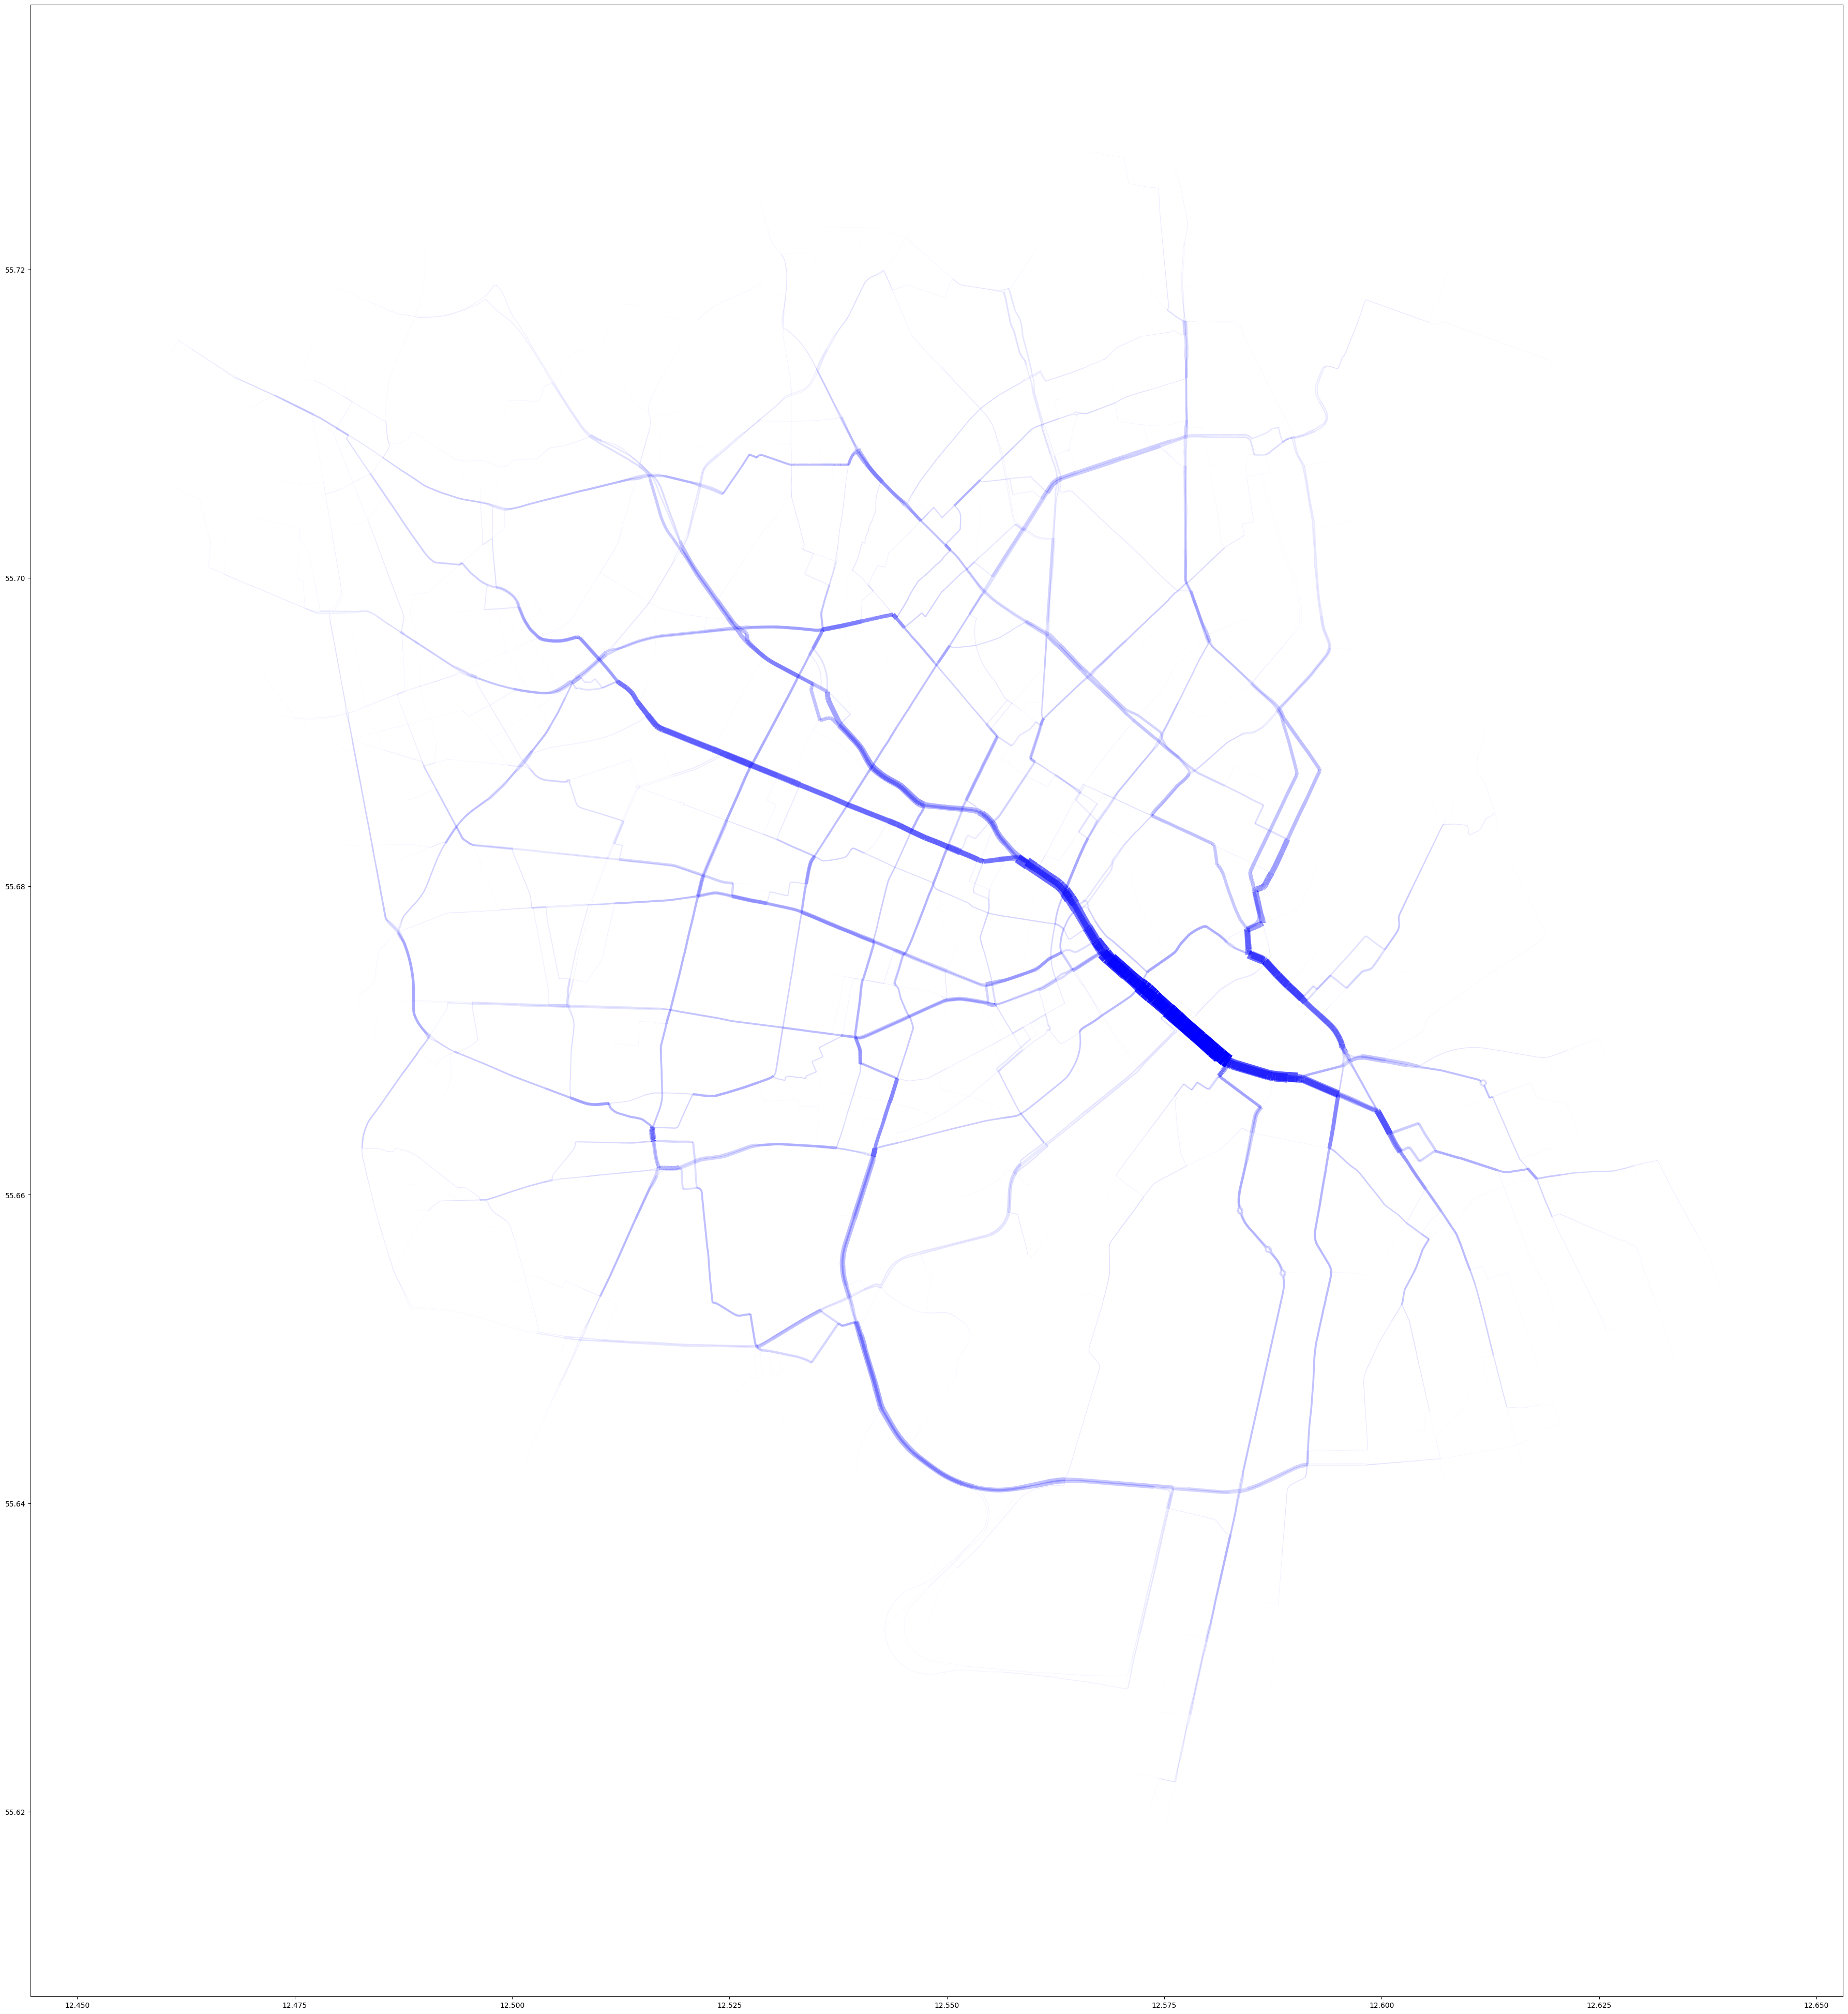

In [31]:
#This plot is edge betweenness centrality based on the 'bc_len_attr' attribute 
lanes = ox.graph_to_gdfs(Gs['carall'], nodes=False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ac = [btw_length_norm[k] for k in btw_length_norm]
#ac = [0.08 if (edges_dict[k]) == meancountfraction else 0.8 for k in edges_dict]
lc = [btw_length_norm[k]*20 for k in btw_length_norm]

ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac, linewidth = lc)


plt.show()

In [116]:
btw_length = nx.edge_betweenness_centrality(Gs['carall'],  weight='length_attr')

In [117]:
btw_length_attr_norm = normalise_edge_dict(btw_length)

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


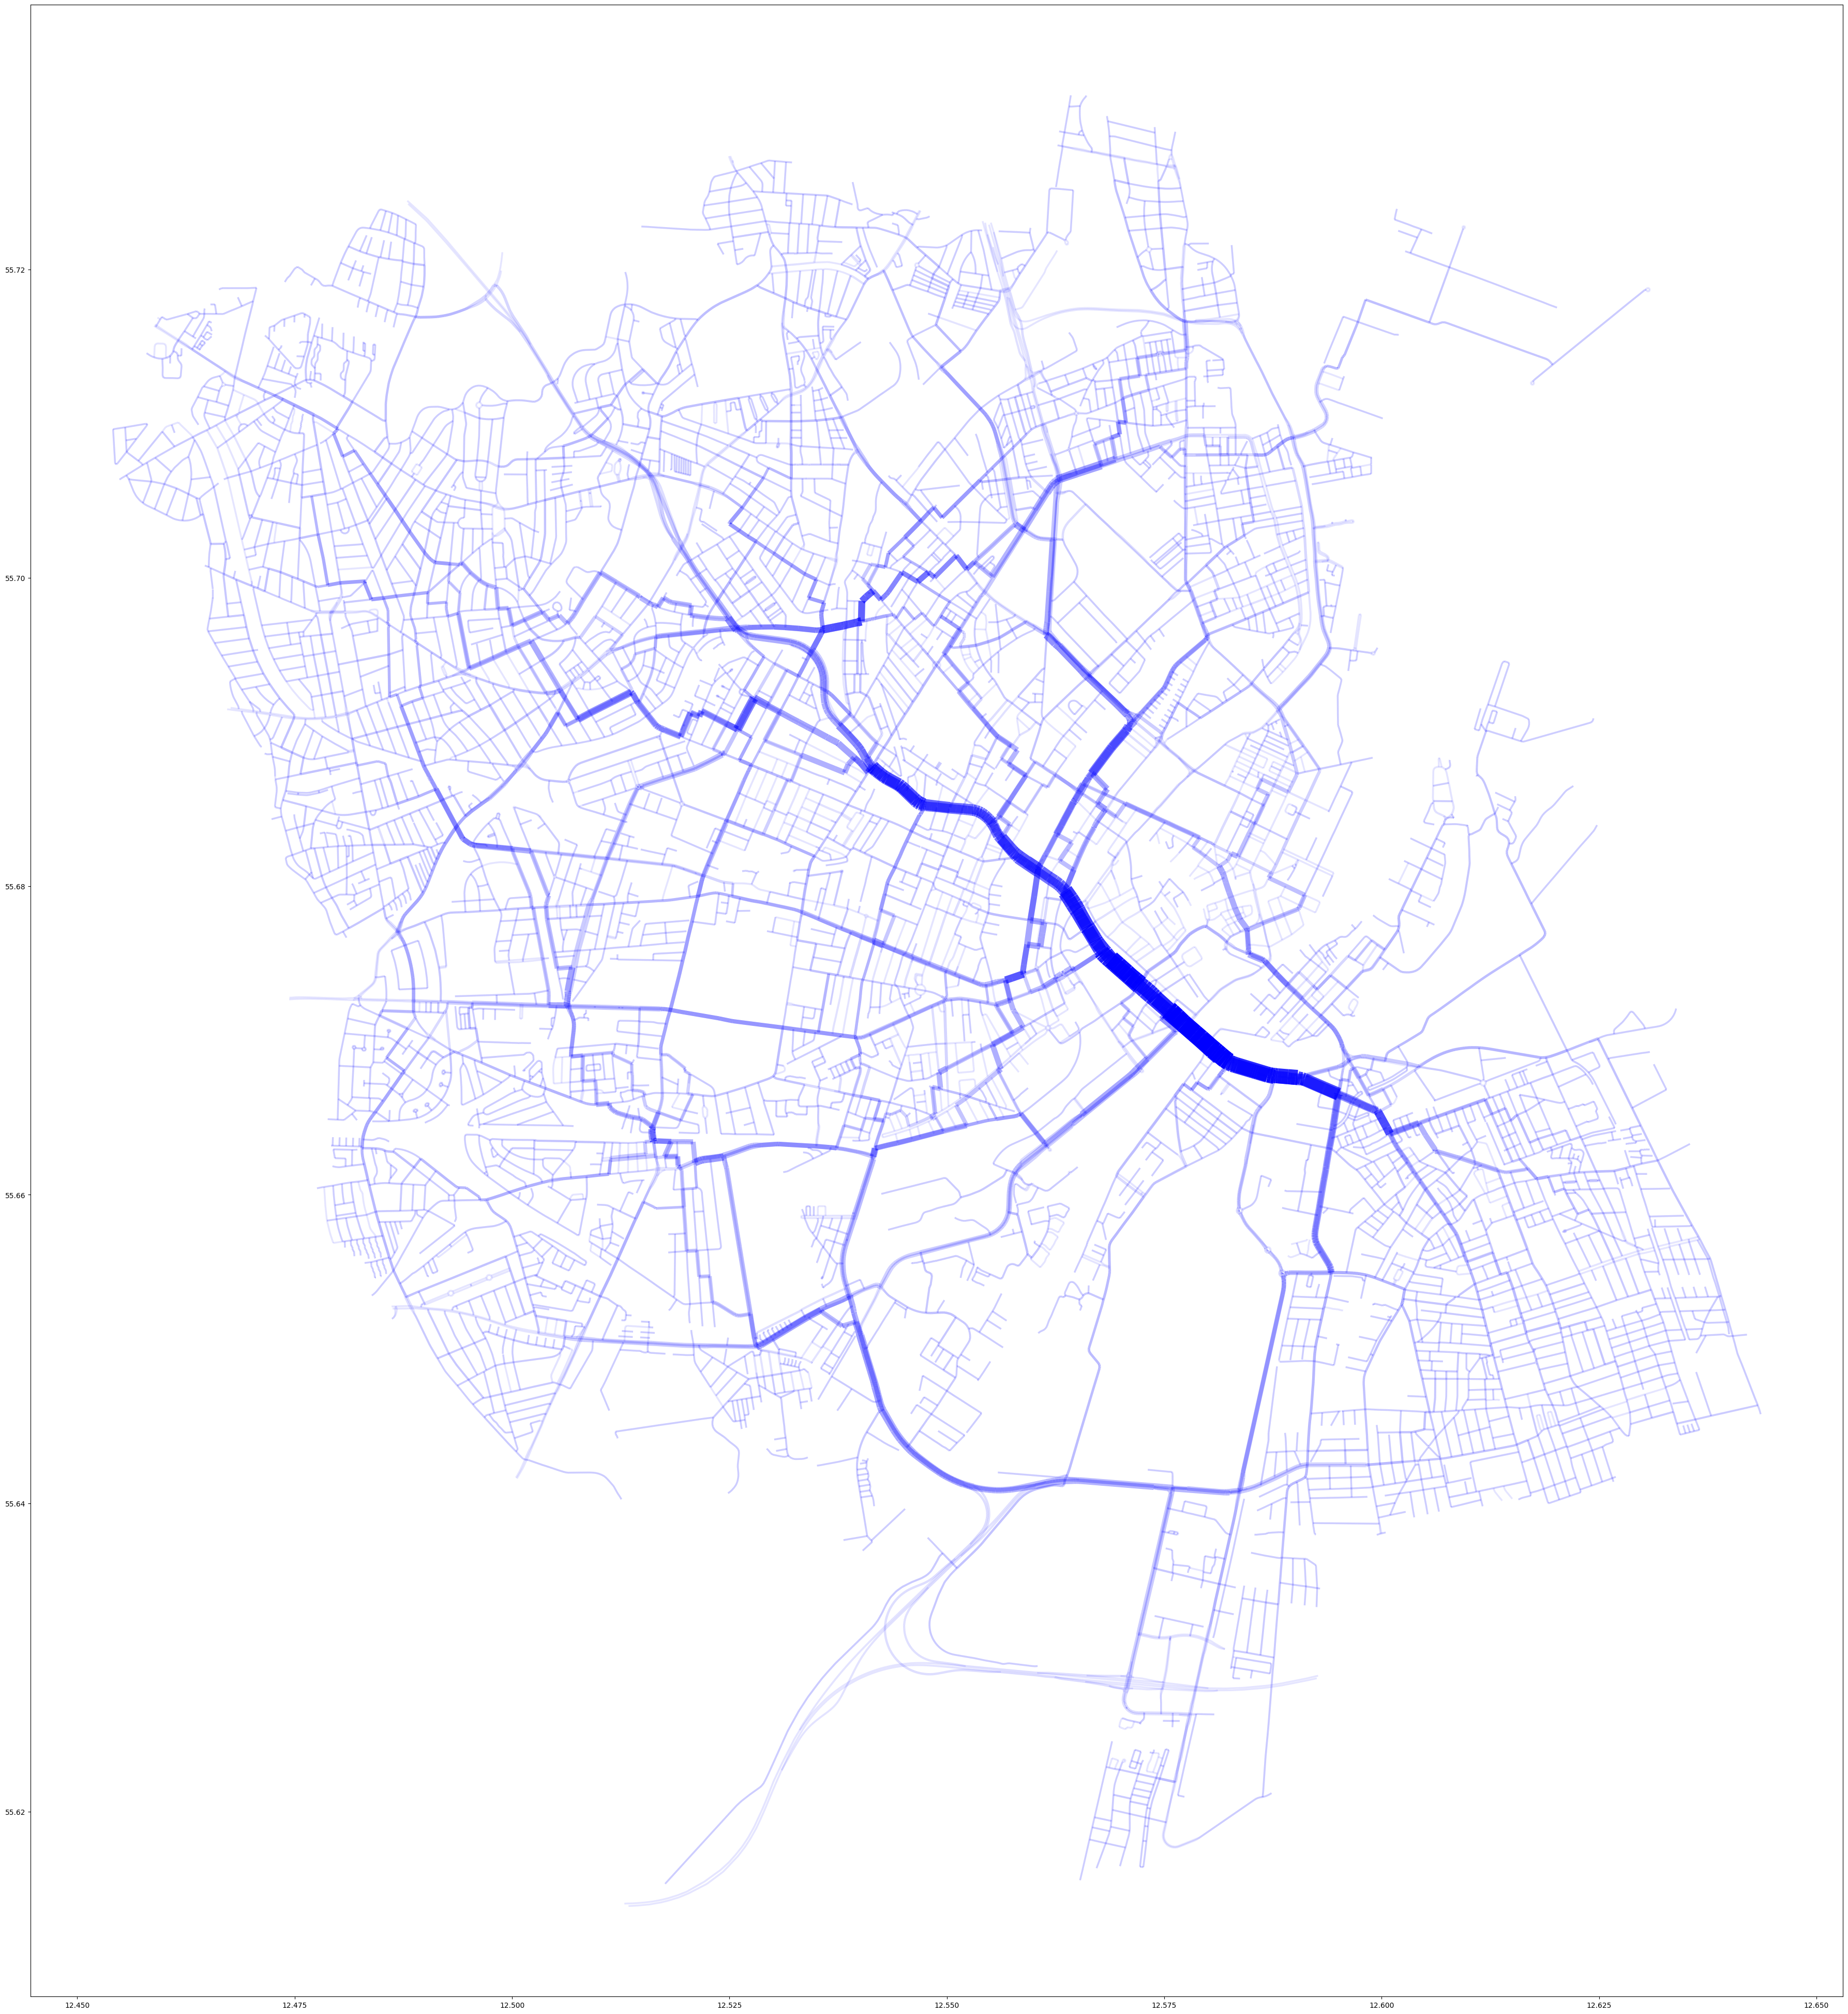

In [120]:
#This plot is edge betweenness centrality based on the 'bc_len_attr' attribute 
lanes = ox.graph_to_gdfs(Gs['carall'], nodes=False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ac = [btw_length_attr_norm[k] for k in btw_length_attr_norm]
#ac = [0.08 if (edges_dict[k]) == meancountfraction else 0.8 for k in edges_dict]
lc = [btw_length_attr_norm[k]*25 for k in btw_length_attr_norm]

ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac, linewidth = lc)


plt.show()

In [ ]:
btw_length

In [121]:
fn = lambda value, x_max, x_min: (value - x_min) / (x_max - x_min)
btw_length_norm = btw_length
# In each inner dict

# find min and max values
max_x = max(btw_length.values())
min_x = min(btw_length.values())

# normalize each value in the dict
for k in btw_length:
    btw_length_norm[k] = fn(btw_length[k], max_x, min_x)

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


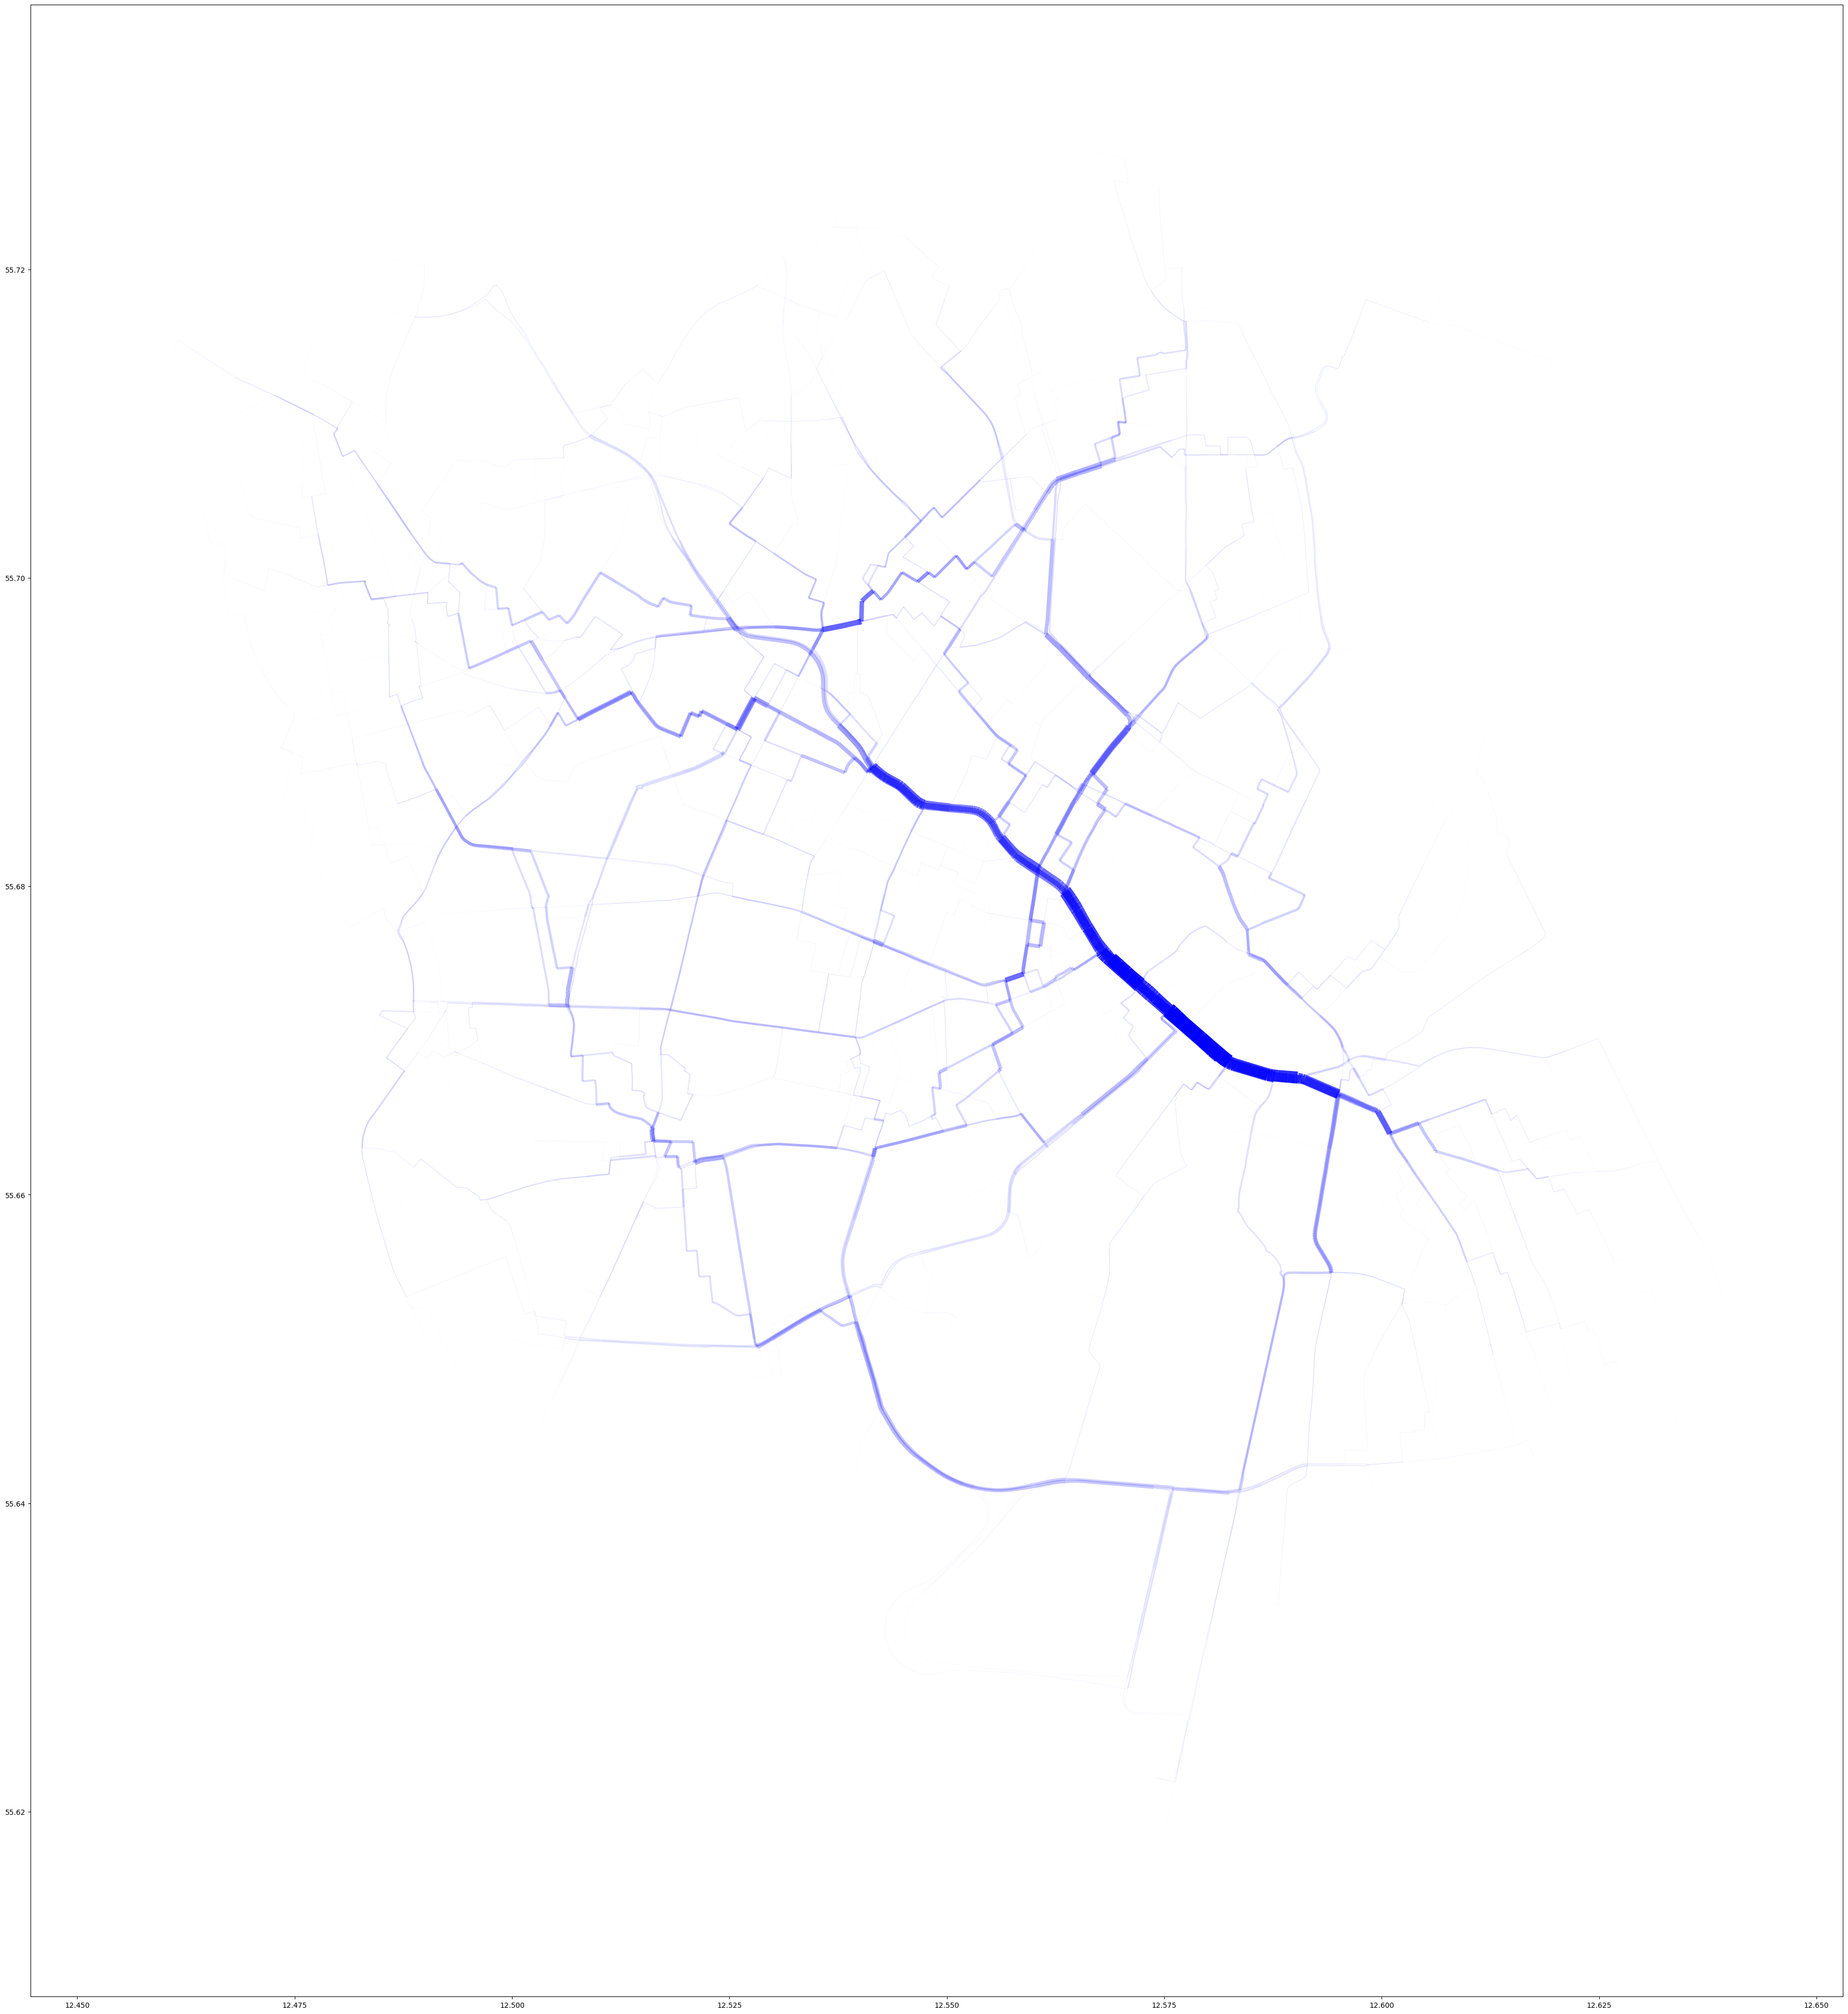

In [122]:
#This plot is edge betweenness centrality based on the 'bc_len_attr' attribute 
lanes = ox.graph_to_gdfs(Gs['carall'], nodes=False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ac = [btw_length_norm[k] for k in btw_length_norm]
#ac = [0.08 if (edges_dict[k]) == meancountfraction else 0.8 for k in edges_dict]
lc = [btw_length_norm[k]*20 for k in btw_length_norm]

ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac, linewidth = lc)


plt.show()

In [ ]:
with open("../../bikenwgrowth_external/data/copenhagen/bikedata/btw_length_attr.pickle", 'wb') as f:
    pickle.dump(btw_length_attr_norm, f)

In [125]:
ox_to_csv(ox.simplify_graph(Gs['carall']), PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall', "_simplified")

copenhagen: Successfully wrote graph carall_simplified


In [126]:
ox.save_graphml(Gs['carall'], "../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml")